<h2>Segmenting Facial Orientation using IsoMap</h2>
<p>In this notebook, we aim to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323. </p>

---




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image
import Matrix_D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

The file isomap.mat contains 698 images, corresponding to different poses of the same face. Each image is given as a 64 $\times$ 64 luminosity map, hence represented as a vector in $\mathbb R^{4096}$. This vector is stored as a row in the file.


In [3]:
images = scipy.io.loadmat('isomap.mat')['images']
images = np.reshape(np.rot90(np.reshape(images,(64,64,698)),k=3,axes=(0,1)),(4096,698)).T
image_array = np.expand_dims(images,axis=2)

With our data and libraries loaded, we will now use the Euclidean distance metric (i.e., in this case, a distance in $\mathbb R^{4096}$) to construct the nearest neighbor graph—vertices corresponding to the images, construct a similarity graph with vertices corresponding to the images, and tune the threshold $\epsilon$ so that each node has at least 100 neighbors (this approach corresponds to the so-called $\epsilon$-Isomap).

### Un-Weighted Adjacency Matrix:

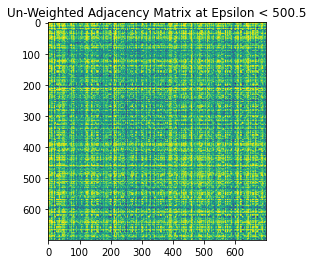

In [5]:
eclu_dist_array = np.sum(np.square(image_array - image_array.T),axis=1)
adj_tester = np.where(eclu_dist_array <= 500.5,1,0)
plt.imshow(adj_tester)
plt.title('Un-Weighted Adjacency Matrix at Epsilon < 500.5')
plt.show()

Given that the assignment called for $\epsilon$-threshold variant of Isomap where this value satisfies the constraint of all nodes having at least 100 neighbors, I arrived at the value of $500.5 = \epsilon$ by iteratively trying values and counting node neighbor frequencies until a proper solution was reached. It is notable that a much lower value of $\epsilon$ could’ve been used but would’ve reduced the density of our matrix. In current form, the graph is especially dense and there are many nodes that are almost fully connected.

---

### Shortest Path Distance Matrix D:

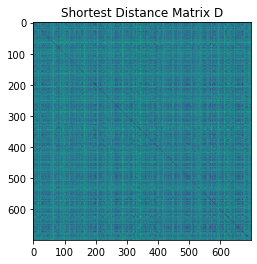

In [6]:
weighted = np.multiply(eclu_dist_array,adj_tester)
W_matrix = np.where(weighted == 0,float('inf'),weighted)
D_matrix = Matrix_D.Matrix_D(W_matrix)
plt.imshow(D_matrix)
plt.title('Shortest Distance Matrix D')
plt.show()

Using the shortest path function generously provided by our Professor, we arrive at the above graphical representation of the shortest path distance matrix D. As we can see the graph is symmetric and diagonalized as we expected. However, this graph alone tells us very little about our data at this point in time. However, it is a very good way to verify our algorithm is being implemented properly up to this point.

---

### Plotting ISOMAP Results:

Using the above D matrix and following the proper Isomap formula implementation in solving for our reduced dimensional embedding’s, we arrive at the following visualization:

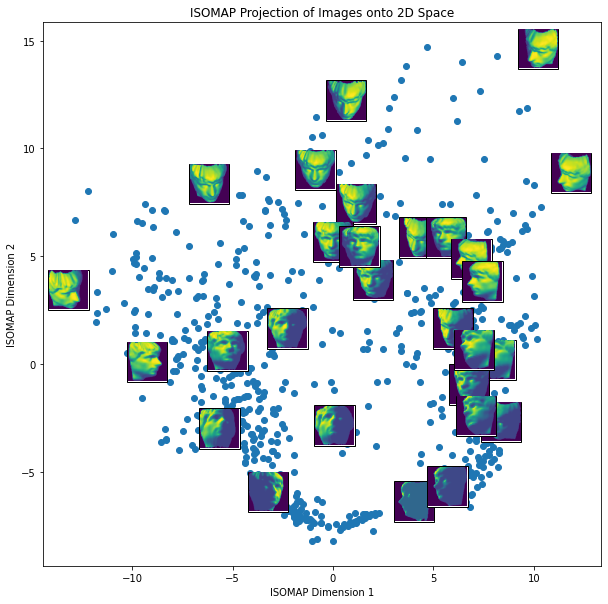

In [7]:
D_squared = np.square(D_matrix)
H = np.subtract(np.identity(D_squared.shape[0]),np.multiply(1/D_squared.shape[0],np.ones((D_squared.shape[0],D_squared.shape[1]))))
C = -(1/2) * (H @ D_squared @ H)
C = C/D_squared.shape[0]
U,Sigma,VT = np.linalg.svd(C)
k = 2
VT_K = VT[0:k,:] 
Sigma_k_root = np.expand_dims(np.sqrt(Sigma[0:k]),1)
ZT = np.multiply(VT_K,Sigma_k_root)
PC_1 = ZT[0,:]
PC_2 = ZT[1,:]
images_album = np.reshape(images,(698,64,64))
images_album_index = [506, 471, 517, 43, 293, 40, 323, 363, 25, 652, 558, 422, 525, 259, 542, 194, 633, 644,100,1,3,78,467,655,333,444,222,111]
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(PC_1, PC_2)
ax.set_title('ISOMAP Projection of Images onto 2D Space')
ax.set_xlabel('ISOMAP Dimension 1')
ax.set_ylabel('ISOMAP Dimension 2')
for i in images_album_index:
        solo_image = images_album[i,:,:]
        imagebox = OffsetImage(solo_image, zoom=0.6)
        ab = AnnotationBbox(imagebox, ZT.T[i], pad=0.1)
        ax.add_artist(ab)
plt.show()

As we can see in the plot above, the Isomap embeddings were able to find very significant structure within the dataset primary centered on the orientation of the face image. In this the graph really speaks for itself in just how well the algorithm was able to identify lighting origination and facial direction from a simple set of images, and cluster them in such an effective manner despite unequal distribution of poses. It is also worth noting that the above output takes on very similar behavior, form, and representation of the Isomap implementation results provided within the supplied research paper.

---


### Manhatten Distance Adjacency Matrix:

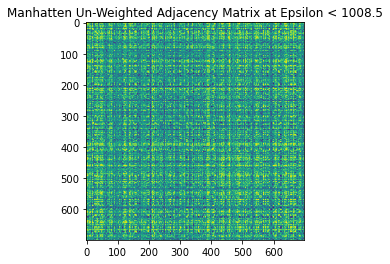

In [8]:
manhatten_distance_array = np.sum(np.abs(image_array - image_array.T),axis=1)
adj_tester_man = np.where(manhatten_distance_array <= 1008.5,1,0)
plt.imshow(adj_tester_man)
plt.title('Manhatten Un-Weighted Adjacency Matrix at Epsilon < 1008.5')
plt.show()

Similar to the implementation above we again solved for the respective adjacency and shortest path distance matrix using the Manhattan distance as our similarity/distance measure. The results are as we expected in symmetry and density very similar to the Euclidian implementation previously discussed. Of notable difference to the Euclidean implementation however is the much larger 𝜖=1008.5 value which is a little more than double the distance threshold of the previous implementation. Again, we see a very dense graph much more so than even the dense adjacency graph from the Euclidian implementation.

---

### Manhatten Distance Shortest Path Distance Matrix:

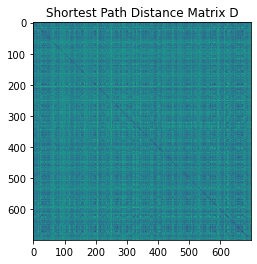

In [9]:
weighted_man = np.multiply(manhatten_distance_array,adj_tester_man)
W_matrix_man = np.where(weighted_man == 0,float('inf'),weighted_man)
D_matrix_man = Matrix_D.Matrix_D(W_matrix_man)
plt.imshow(D_matrix_man)
plt.title('Shortest Path Distance Matrix D')
plt.show()

### Manhatten Distance ISOMAP Output:

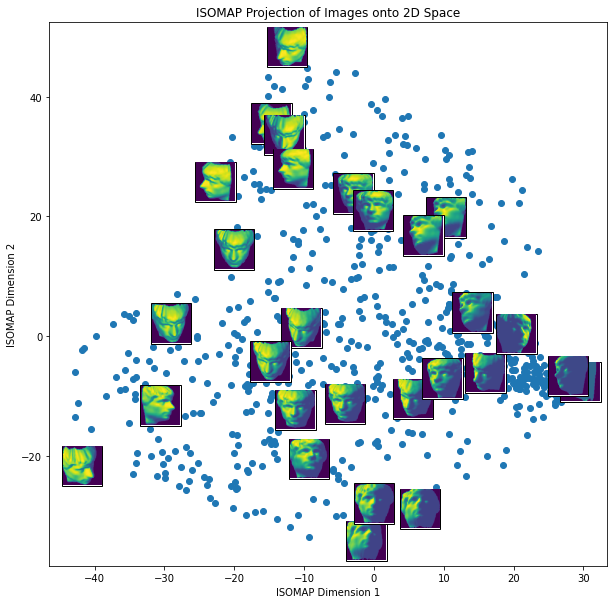

In [10]:
D_squared_man = np.square(D_matrix_man)
H_man = np.subtract(np.identity(D_squared_man.shape[0]),np.multiply(1/D_squared_man.shape[0],np.ones((D_squared_man.shape[0],D_squared_man.shape[1]))))
C_man = -(1/2) * (H_man @ D_squared_man @ H_man)
C_man = C_man/D_squared_man.shape[0]
U_man,Sigma_man,VT_man = np.linalg.svd(C_man)
k_man = 2
VT_K_man = VT_man[0:k,:] 
Sigma_k_root_man = np.expand_dims(np.sqrt(Sigma_man[0:k]),1)
ZT_man = np.multiply(VT_K_man,Sigma_k_root_man)
PC_1_man = ZT_man[0,:]
PC_2_man = ZT_man[1,:]
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(PC_1_man, PC_2_man)
ax.set_title('ISOMAP Projection of Images onto 2D Space')
ax.set_xlabel('ISOMAP Dimension 1')
ax.set_ylabel('ISOMAP Dimension 2')
for i in images_album_index:
        solo_image = images_album[i,:,:]
        imagebox = OffsetImage(solo_image, zoom=0.6)
        ab = AnnotationBbox(imagebox, ZT_man.T[i], pad=0.1)
        ax.add_artist(ab)
plt.show()

As we can see from the output above, our choice of using the Manhattan distance metric for the Isomap implementation did far worse of a job than the prior implementation with Euclidian. Although, the graph still does provide some interesting structure to the data, but lacks the effectiveness or precision of the previous Isomap implementation structure which better separated the data and expressed more concrete logical separation of clusters. Our choice of $\epsilon$ allowed for high connectivity so in the future one could explore how differing values could impact the performance of the Manhattan implementation of Isomap.


---

## PCA Version:

We can directly compare the performance of non-linear reduction methods like Isomap by comparing the above outputs to a linear reduction method such as PCA performed on the same dataset. The results of the PCA reduction on the faces dataset is show in the output below:


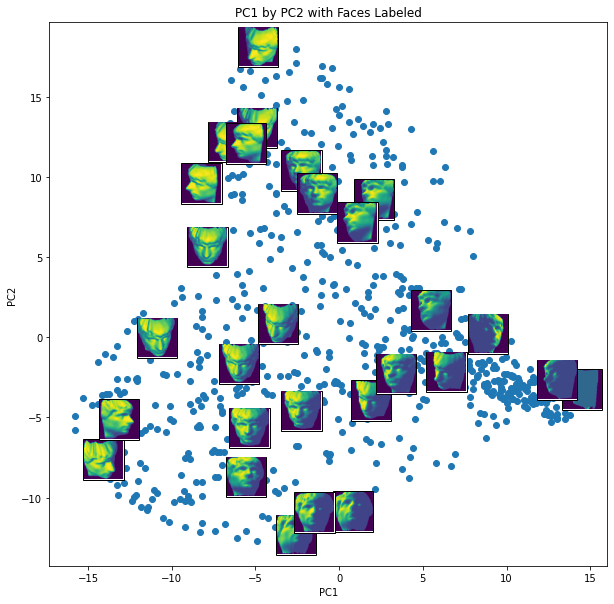

In [11]:
pc_im_array = images.T
pc_im_array_centered = pc_im_array - np.expand_dims(np.average(pc_im_array,axis=1),axis=1)
pc_im_cov = pc_im_array_centered.dot(pc_im_array_centered.T)
pc_U,pc_Sigma,pc_VT = np.linalg.svd(pc_im_cov)
k=2
PC1_ISO = pc_VT[0,:].T.dot(pc_im_array_centered)
PC2_ISO = pc_VT[1,:].T.dot(pc_im_array_centered)
PC_ISO = np.vstack((PC1_ISO,PC2_ISO))
fig2, ax2 = plt.subplots(figsize=(10,10))
plt.scatter(PC1_ISO, PC2_ISO)
ax2.set_title('PC1 by PC2 with Faces Labeled')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
for i in images_album_index:
    solo_image = images_album[i,:,:]
    imagebox = OffsetImage(solo_image, zoom=0.6)
    ab = AnnotationBbox(imagebox, PC_ISO.T[i], pad=0.1)
    ax2.add_artist(ab)
plt.show()

The PCA implementation gives a very similar result to that of Isomap with the Manhattan distance implementation. This is probably not coincidence as under Isomap the more connected our adjacency and D matrix are the closer we get to a simple linear dimensionality reduction method like PCA. The strength of Isomap lies in identifying logical local low dimensional connections and separating out seemingly close higher dimensional ones. The reason we see the Isomap Manhattan implementation so close to our PCA output is because the value of epsilon chose was very large leaving only a few nodes in the graph not fully connected. However, again PCA in its own right does a respectable job at defining and identifying some structure within the data. However, the Euclidian Isomap implementation by far blows past the competition in effectiveness.